In [3]:
import numpy as np
import pandas as pd
import re
import sys
from tqdm import tqdm


In [4]:
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages")

In [5]:
from fastai.text import *

In [6]:
#read in data
df = pd.read_csv('realdonaldtrump.csv')

In [7]:
#im really only interested in trump tweets after he became a political figure, 
#so I'm dropping tweets from before he anncounced his canidacy
mask = (df['date'] > '2015-06-16')
df = df.loc[mask]

In [8]:
#slim down data
data = df["content"]
data.columns = ["text"]
train = data

train.to_csv("./trump_tweet_gen_train.csv")

In [9]:
def remove_punc(text):
    #helper function to remove punctuation
    new_text = re.sub(r'[^\w\s]', '', text) 
    return new_text

In [10]:
#removing the punctuation
for i in train.index:
    train.loc[i] = remove_punc(train.loc[i])

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [12]:
train = pd.DataFrame(train)
train

,content
23278,realJoeMurray Hopefully tomorrow is the day ...
23279,brentcfritz Today is the day America becomes g...
23280,insuraider realDonaldTrump is going to make...
23281,DONJUBBER realDonaldTrump Shock the world ...
23282,PianoBecca realDonaldTrump No Amercian real...
...,...
43347,Joe Biden was a TOTAL FAILURE in Government He...
43348,Will be interviewed on seanhannity tonight at...
43349,pictwittercom3lm1spbU8X
43350,pictwittercomvpCE5MadUz


In [13]:
#create databunch
data = (TextList.from_df(train, cols='content')
                .split_by_rand_pct(0.1)
                .label_for_lm()  
                .databunch(bs=48))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


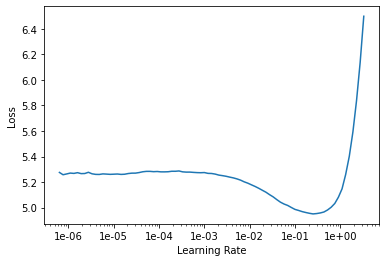

In [33]:
#instantiate model
model = language_model_learner(data, AWD_LSTM, drop_mult=0.1, model_dir = '/Users/user/desktop/metis/projects/metis-project-4/tweet_generator_model')

#find learning rate
model.lr_find()

#use LR at steepest point (re-ran just to show plot)
model.recorder.plot()

In [35]:
# Fit the model with optimal learning rate
model.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.084717,3.889917,0.301723,07:54


In [17]:
#test model on some fun prompts
print(model.predict("I think CNN is", 20, temperature=0.75))

I think CNN is not a bad guy It is true CNN and Fake News Media is looking at


In [18]:
print(model.predict("I think Fox News is", 20, temperature=0.75))

I think Fox News is a joke and its that is a joke xxbos The story is about the American Flag


In [19]:
print(model.predict("Russia has", 20, temperature=0.75))

Russia has a great impact on our country xxbos The Russian Witch Hunt continues for years and has


In [20]:
print(model.predict("Mueller Report", 20, temperature=0.75))

Mueller Report is a virtual Mueller Report that is Mueller Report and other thought positions It is


In [21]:
print(model.predict("Impeachment", 20, temperature=0.75))

Impeachment is one of the greatest political expenses in the history of the United States This is the


In [22]:
print(model.predict("COVID is a ", 20, temperature=0.75))

COVID is a  Foreign Intelligence Committee reporter who speaks about all of Hillary s campaign and the President


In [25]:
import pickle

In [31]:
# save the model to disk
model.export('trump_tweet_gen.pkl')